## Behavior cloning for end to end driver less cars


In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten, Lambda, Dropout
from keras.layers import Cropping2D
# from keras.utils.visualize_util import plot
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


In [2]:
import keras
print (keras.__version__)

2.0.0


## Load the data from simulator

In [3]:
project_directory = "/Users/kdalwani/cnd/CarND-Behavioral-Cloning-P3/data/sample_training_data/"
log_file_path = "driving_log.csv"

In [4]:
def get_log_files_pd(project_dir, log_file_path):
    lines = []
    log_pd = pd.read_csv(project_dir + log_file_path)
    return log_pd


In [5]:
log_pd = get_log_files_pd(project_directory, log_file_path)

In [6]:
log_pd.head()
print (log_pd.count())

center      8036
left        8036
right       8036
steering    8036
throttle    8036
brake       8036
speed       8036
dtype: int64


In [7]:
log_pd.head()


center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   
1  IMG/center_2016_12_01_13_30_48_404.jpg   
2  IMG/center_2016_12_01_13_31_12_937.jpg   
3  IMG/center_2016_12_01_13_31_13_037.jpg   
4  IMG/center_2016_12_01_13_31_13_177.jpg   

                                   left  \
0  IMG/left_2016_12_01_13_30_48_287.jpg   
1  IMG/left_2016_12_01_13_30_48_404.jpg   
2  IMG/left_2016_12_01_13_31_12_937.jpg   
3  IMG/left_2016_12_01_13_31_13_037.jpg   
4  IMG/left_2016_12_01_13_31_13_177.jpg   

                                   right  steering  throttle  brake      speed  
0  IMG/right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0  22.148290  
1  IMG/right_2016_12_01_13_30_48_404.jpg       0.0       0.0    0.0  21.879630  
2  IMG/right_2016_12_01_13_31_12_937.jpg       0.0       0.0    0.0   1.453011  
3  IMG/right_2016_12_01_13_31_13_037.jpg       0.0       0.0    0.0   1.438419  
4  IMG/right_2016_12_01_13_31_13_177.jpg       0.0       0.0    0.0   1.418236

In [8]:
def load_training_data(log_pd, project_directory, add_flip_images=True, add_left_right_images=True, correction=0.2, 
      from_simulator=False):
    per_record = 1000
    X_train = []
    y_data = []
    if add_flip_images:
        print ("Adding flip images as well.")
    else:
        print ("Not adding flip images.")
    if add_left_right_images:
        print ("Adding left right images as well.")
    else:
        print ("Not adding left right images.")

    for index, row in log_pd.iterrows():
        if index % per_record == 0:
            print(".", end=" ")
        image_path = row['center']
        sterring_val = float(row['steering'])
        image_path = project_directory + image_path
        img = cv2.imread(image_path)    
        X_train.append(img)
        y_data.append(sterring_val)
        if add_flip_images:
            X_train.append(cv2.flip(img, 1))
            y_data.append(sterring_val * -1.0)
        if add_left_right_images:
            
            image_path_left = row['left']
            sterring_val_left = sterring_val + correction
            image_path_left = project_directory + row['left']
            img = cv2.imread(image_path_left)    
            X_train.append(img)
            y_data.append(sterring_val_left)

            image_path_right = row['right']
            sterring_val_right = sterring_val - correction
            image_path_right = project_directory + row['right']
            img = cv2.imread(image_path_right)    
            X_train.append(img)
            y_data.append(sterring_val_right)
        
    return X_train, y_data

In [9]:
def load_training_data_2(log_pd, project_directory, add_left_right_images=True, correction=0.2, 
      from_simulator=False):
    per_record = 1000
    X_train = []
    y_data = []
    if add_left_right_images:
        print ("Adding left right images as well.")
    else:
        print ("Not adding left right images.")

    for index, row in log_pd.iterrows():
        if index % per_record == 0:
            print(".", end=" ")
        image_path = row['center']
        sterring_val = float(row['steering'])
        image_path = project_directory + image_path
        img = cv2.imread(image_path)    
        X_train.append(img)
        y_data.append(sterring_val)
        if add_left_right_images:
            image_path_left = row['left']
            sterring_val_left = sterring_val + correction
            image_path_left = project_directory + row['left']
            img = cv2.imread(image_path_left)    
            X_train.append(img)
            y_data.append(sterring_val_left)

            image_path_right = row['right']
            sterring_val_right = sterring_val - correction
            image_path_right = project_directory + row['right']
            img = cv2.imread(image_path_right)    
            X_train.append(img)
            y_data.append(sterring_val_right)

    X_train_flip, y_data_flip = add_flip_images(X_train, y_data)    
    
    X_train = np.concatenate([X_train, X_train_flip])
    y_data = np.concatenate([y_data, y_data_flip])
    
    return X_train, y_data

def add_flip_images(X_data, y_data):
    per_record = 1000
    X_train_flip = []
    y_data_flip = []
    for index in range(len(X_data)):
        if index % per_record == 0:
            print(".", end=" ")
        img = X_data[index]
        sterring_val = y_data[index]
        X_train_flip.append(cv2.flip(img, 1))
        y_data_flip.append(sterring_val * -1.0)
    return X_train_flip, y_data_flip
    

## Load images using Generator

In [33]:
import os
import csv


from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(log_pd, test_size=0.2)

import cv2
import numpy as np
import sklearn

batch_size = 128
def generator(log_pd, project_directory, add_left_right_images=True, correction=0.2, 
      from_simulator=False, batch_size=32):
    samples = log_pd.as_matrix()
    num_samples = len(samples)
    per_record = 1000
    X_train = []
    y_data = []
    if add_left_right_images:
        print ("Adding left right images as well.")
    else:
        print ("Not adding left right images.")
    
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                image_path = batch_sample[0]
                sterring_val = float(batch_sample[3])
                image_path = project_directory + image_path
                img = cv2.imread(image_path)    
                images.append(img)
                angles.append(sterring_val)
                if add_left_right_images:
                    sterring_val_left = sterring_val + correction
                    image_path_left = project_directory + batch_sample[1]
                    img = cv2.imread(image_path_left)    
                    images.append(img)
                    angles.append(sterring_val_left)

                    sterring_val_right = sterring_val - correction
                    image_path_right = project_directory +  batch_sample[2]
                    img = cv2.imread(image_path_right)    
                    images.append(img)
                    angles.append(sterring_val_right)
            
            images_flip, images_y_data_flip = add_flip_images(images, angles)  
            X_train = np.concatenate([images, images_flip])
            y_train = np.concatenate([angles, images_y_data_flip])

            # trim image to only see section with road
#             X_train = np.array(X_train)
#             y_train = np.array(y_data)
            yield sklearn.utils.shuffle(X_train, y_train)

In [28]:
train_generator = generator(train_samples, project_directory, batch_size=batch_size)
validation_generator = generator(validation_samples, project_directory, batch_size=batch_size)
len_train_samples = len(train_samples)
len_valid_samples = len(validation_samples)

In [29]:
train_gen_sample = next(train_generator)
valid_gen_sample = next(validation_generator)

Adding left right images as well.
. Adding left right images as well.
. 

In [13]:
#X_images, steerings = load_training_data_2(log_pd, project_directory)
#print ("done")

In [14]:
#print ("X train length:", len(X_images))
#print ("Y train length:", len(steerings))

In [15]:
def plot_sample_train_data(X_data, y_data, images_to_plot=20, images_per_row=4):
    total_rows = (np.ceil)(images_to_plot / images_per_row)
    idx = np.random.choice(range(0, len(X_data)), images_to_plot, replace=False)
    f, axes = plt.subplots(figsize=(25,25))
    for i, index in enumerate(idx):
        plt.subplot(total_rows, images_per_row, i+1)
        plt.axis("off")
        plt.imshow(X_data[index].astype('uint8'))
        plt.title("{:.3f}".format(y_data[index]))
    # plot the mean image    
    plt.imshow(np.mean(X_data, axis=0).astype("uint8"))
    plt.title("Mean image: {:.3f}".format(np.mean(y_data)))
    plt.show()
    


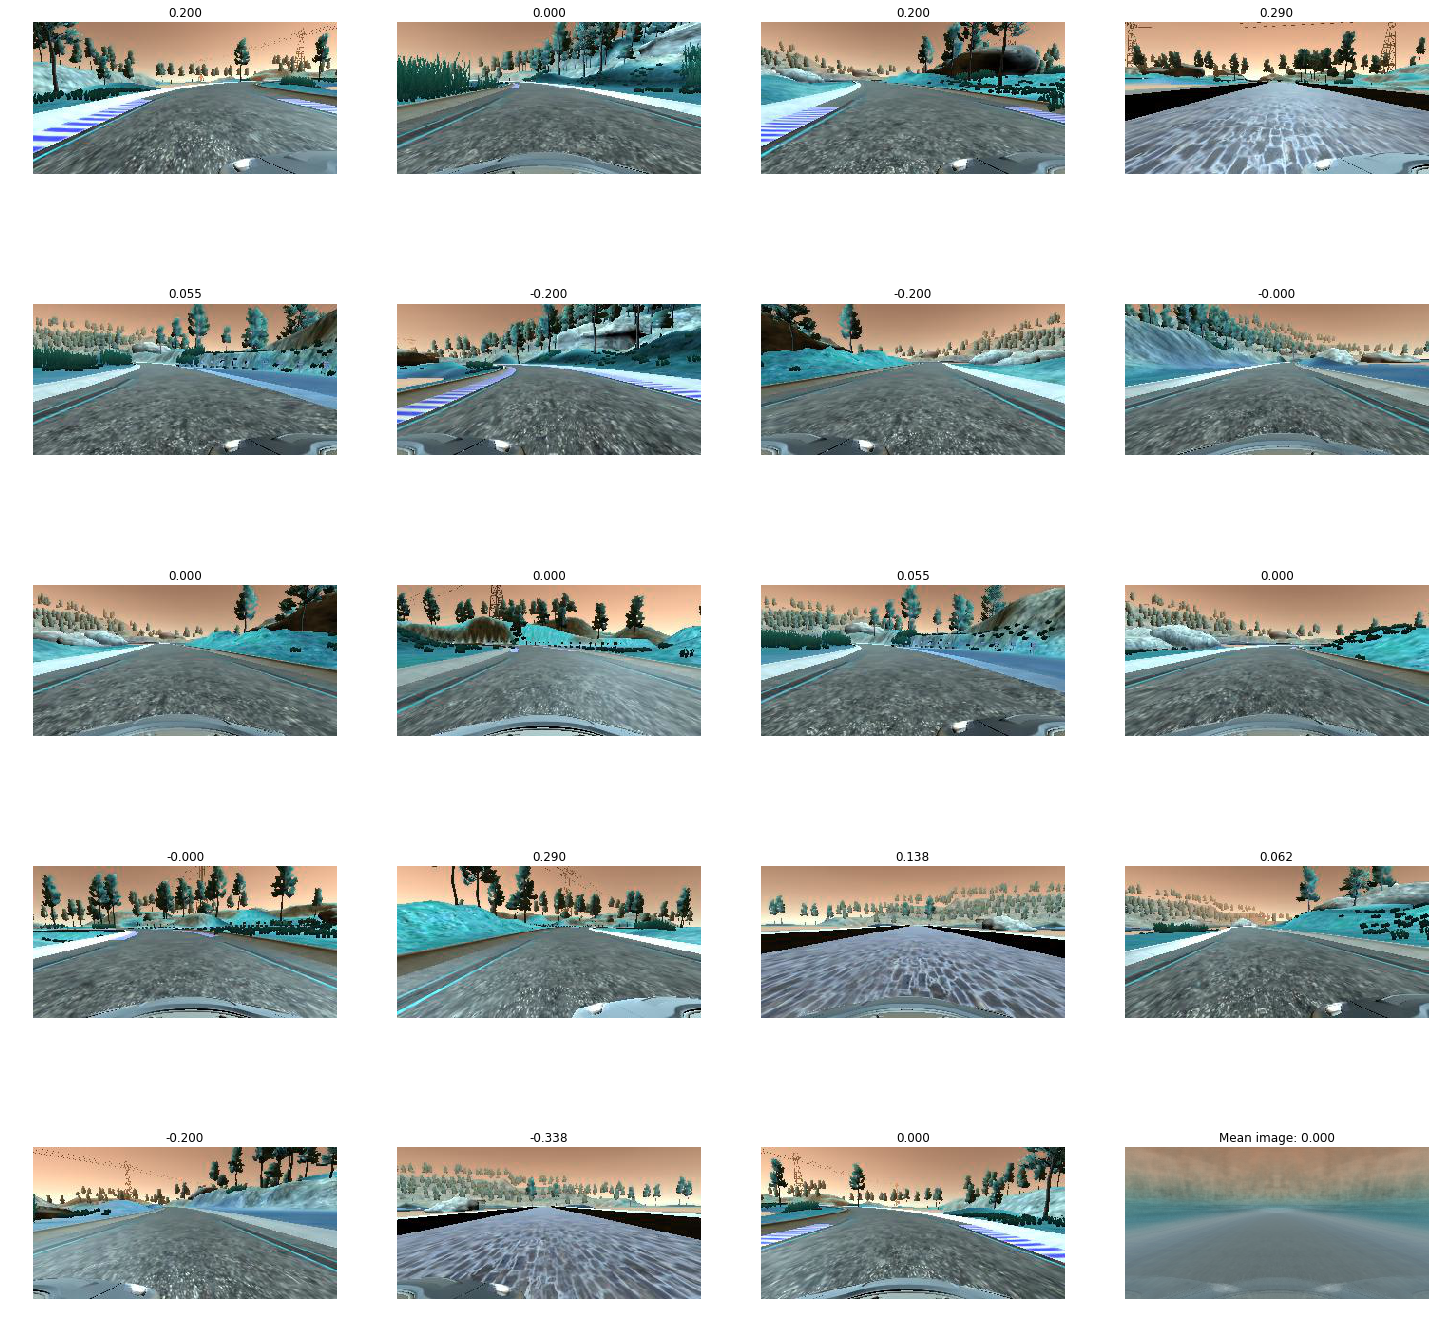

In [16]:
plot_sample_train_data(train_gen_sample[0], train_gen_sample[1], images_to_plot=20)

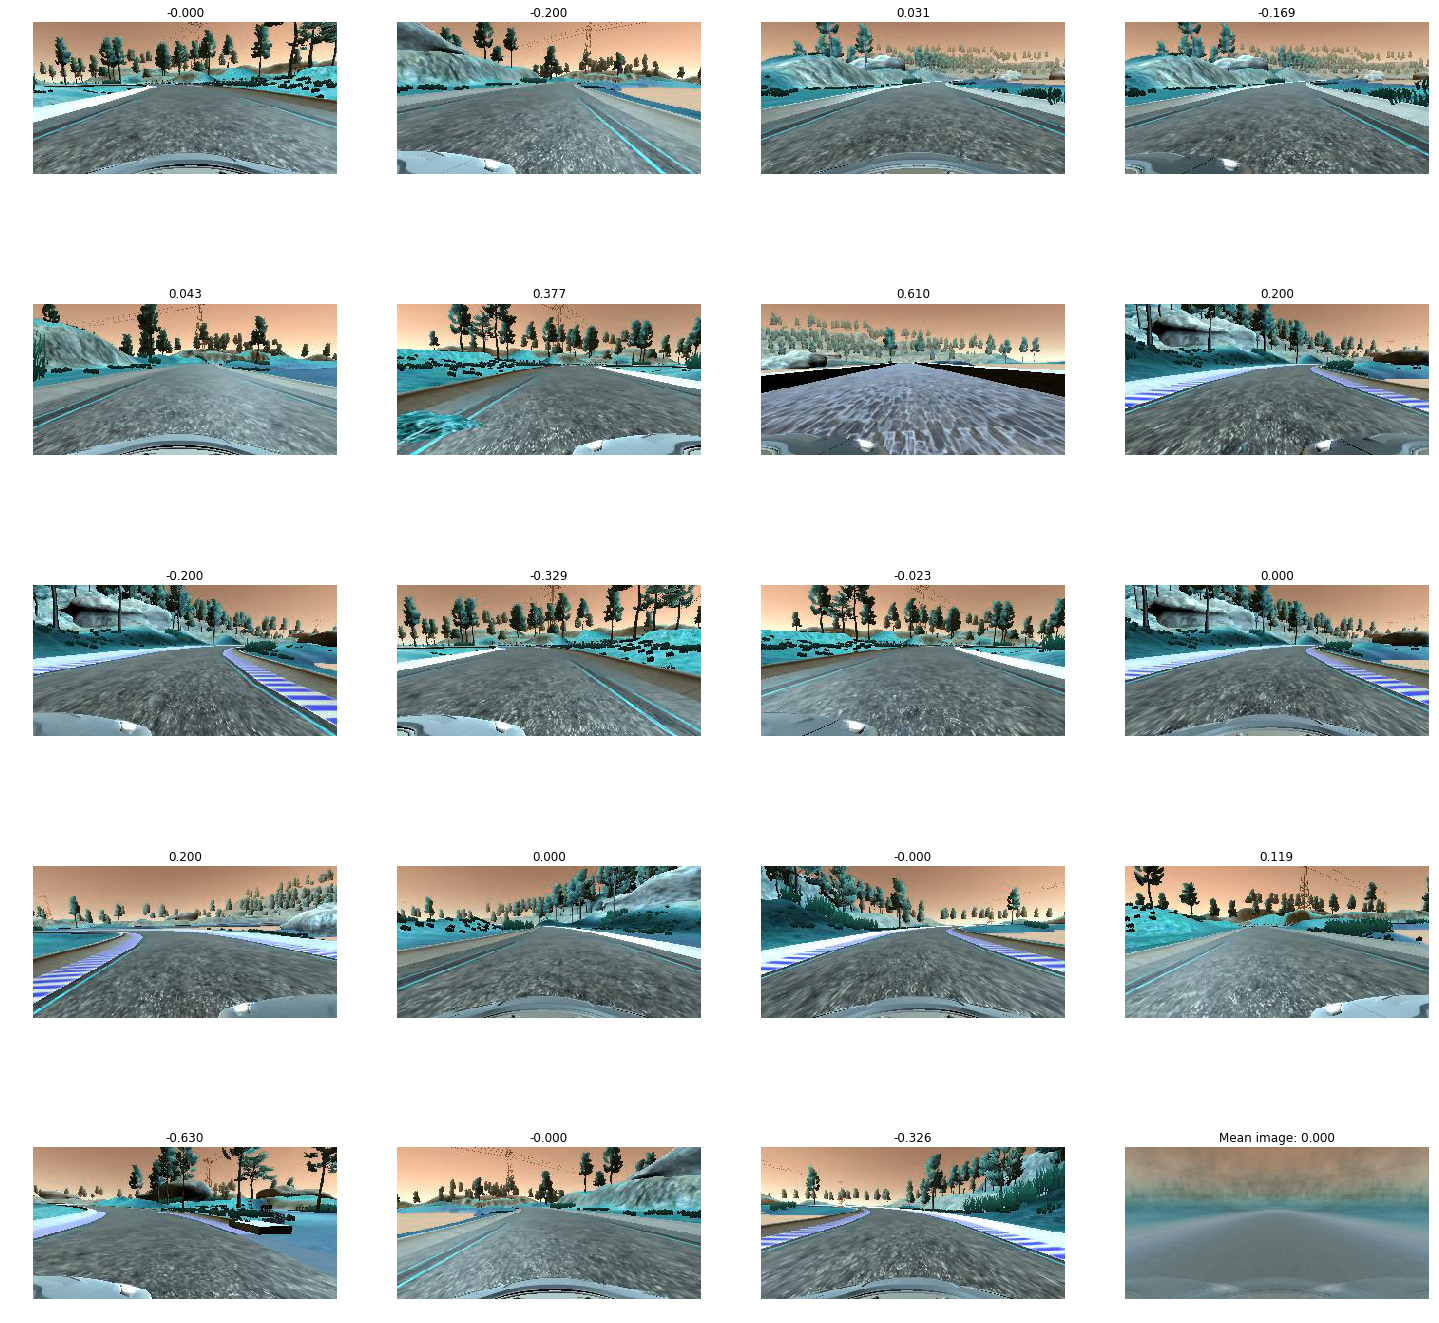

In [77]:
plot_sample_train_data(valid_gen_sample[0], valid_gen_sample[1], images_to_plot=20)

## Plot mean image

In [78]:
# plt.imshow(np.mean(X_images, axis=0).astype("uint8"))
# plt.title("Mean image: {:.3f}".format(np.mean(steerings)))
# plt.show()


In [32]:
# do the training 

# X_train, y_train = np.array(X_images), np.array(steerings)
print (train_gen_sample[0][0].shape)
print (len(train_gen_sample[0]))

(160, 320, 3)
768


In [18]:
y_pd = pd.Series(train_gen_sample[1])
y_pd.describe()

count    1.920000e+02
mean     5.782412e-19
std      1.980234e-01
min     -4.818362e-01
25%     -2.000000e-01
50%      0.000000e+00
75%      2.000000e-01
max      4.818362e-01
dtype: float64

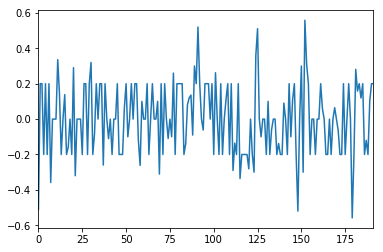

In [81]:
y_pd.plot()

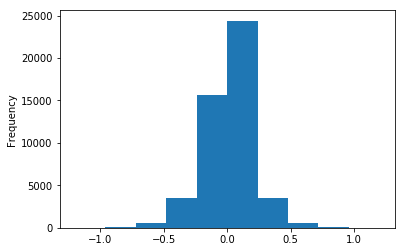

In [201]:
y_pd.plot(kind='hist')

In [19]:
def plot_model_history(histroy):

    # summarize history for loss
    plt.plot(histroy.history['loss'])
    plt.plot(histroy.history['val_loss'])
    plt.legend(['train', 'val'], loc='upper left')

    # summarize history for loss
    plt.title('model loss Train vs Validation')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [38]:
width, height, depth = train_gen_sample[0][0].shape
num_pixels = (width * height* depth)
from keras.utils import plot_model
# model_path = "baseline.h5"
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


def run_model(model, training_data, target_data, model_path, epochs = 10):
    model.compile(loss='mse', optimizer='adam')
    history = model.fit(training_data, target_data, validation_split=0.2,
                        shuffle=True, epochs=epochs, verbose=1)
    print ("Plotting the model architecture:")
    plot_model(model, to_file=model_path + '_architecture.png', show_shapes=True)    

    SVG(model_to_dot(model).create(prog='dot', format='svg'))    
    model_path = model_path + ".model"
    print ("saving the model file:" + model_path)
    model.save(model_path)
    plot_model_history(history)
    return model, history

def run_baseline_model(training_data, target_data, epochs = 10):
    model = Sequential()
    model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (width, height, depth)))
    model.add(Flatten())
    model.add(Dense(1))
    
    return run_model(model, training_data, target_data, "baseline_model", epochs=epochs)

from keras.layers.convolutional import Conv2D, MaxPooling2D

def run_lenet_model(training_data, target_data, dropout=0.5, epochs = 10, model_prefix=""):
    model = Sequential()
    model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (width, height, depth)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))    

    # layer 1 Conv. + Relu + Max Pool
    model.add(Conv2D(6, kernel_size=(5, 5),
                        strides=(1, 1), padding='valid',    
                        activation='relu', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(Dropout(dropout))

    
    # layer 2 Conv. + Relu + Max Pool
    model.add(Conv2D(16, kernel_size=(5, 5),
                        strides=(1, 1), padding='valid',    
                        activation='relu', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1)))    
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    model_key = "epoch_" + str(epochs) + "_dropout_" + str(dropout)
    
    return run_model(model, training_data, target_data, model_prefix + "_lenet_model_" + model_key , epochs=epochs)

def create_nvdia_model(dropout=0.5):
    
#     https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
#     https://github.com/mxbi/carnd-behavioural-cloning/blob/master/model.py#L26
#         https://discussions.udacity.com/t/help-stuck-just-cant-get-a-full-lap-on-the-track/240144/11
#         https://discussions.udacity.com/t/different-car-behavior-to-each-training-and-tuning-process/240110/13
    model = Sequential()
    model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape = (width, height, depth)))
    model.add(Cropping2D(cropping=((50,20), (0,0))))    

    # layer 1 Conv. + Relu + Max Pool
    model.add(Conv2D(24, kernel_size=(5, 5),
                        strides=(1, 1), padding='valid',    
                        activation='relu', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(Dropout(dropout))

    
    # layer 2 Conv. + Relu + Max Pool
    model.add(Conv2D(36, kernel_size=(5, 5),
                        strides=(1, 1), padding='valid',    
                        activation='relu', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(Dropout(dropout))

    # layer 3 Conv. + Relu + Max Pool
    model.add(Conv2D(48, kernel_size=(5, 5),
                        strides=(1, 1), padding='valid',    
                        activation='relu', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))    
    model.add(Dropout(dropout))

    # layer 4 Conv. + Relu + Max Pool
    model.add(Conv2D(64, kernel_size=(3, 3),
                        strides=(1, 1), padding='valid',    
                        activation='relu', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(1,1)))    
    model.add(Dropout(dropout))

    # layer 5 Conv. + Relu + Max Pool
    model.add(Conv2D(64, kernel_size=(3, 3),
                        strides=(1, 1), padding='valid',    
                        activation='relu', use_bias=True))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))    
    model.add(Dropout(dropout))
    
    # 3 FC layers 
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model


def train_run_nvida_model(training_data, target_data, dropout=0.5, epochs = 10, model_prefix=""):
    nvdia_model = create_nvdia_model(dropout=dropout)

    model_key = "epoch_" + str(epochs) + "_dropout_" + str(dropout)
    model_prefix = model_prefix + "_nvdia_model_" + model_key
    
    return run_model(nvdia_model, training_data, target_data, model_prefix, epochs=epochs)


def run_model_with_gen(model, train_generator, validation_generator, len_train_samples, len_valid_samples,
                       model_path, epochs = 10):
    model.compile(loss='mse', optimizer='adam')
    history = model.fit_generator(train_generator, steps_per_epoch= len_train_samples, 
                        validation_data=validation_generator, validation_steps=len_valid_samples, 
                        nb_epoch=epochs)
    print ("Plotting the model architecture:")
    plot_model(model, to_file=model_path + '_architecture.png', show_shapes=True)    

    SVG(model_to_dot(model).create(prog='dot', format='svg'))    
    model_path = model_path + ".model"
    print ("saving the model file:" + model_path)
    model.save(model_path)
    plot_model_history(history)
    return model, history

def train_run_nvida_model_with_gen(train_generator, validation_generator, len_train_samples,
                                   len_valid_samples, dropout=0.5, epochs = 10, model_prefix=""):
    nvdia_model = create_nvdia_model(dropout=dropout)

    model_key = "epoch_" + str(epochs) + "_dropout_" + str(dropout)
    model_prefix = model_prefix + "_nvdia_model_" + model_key
    
    return run_model_with_gen(nvdia_model, train_generator, validation_generator, 
                                (int)(len_train_samples/batch_size), (int)(len_valid_samples/batch_size),
                                model_prefix, epochs=epochs)
#SVG(model_to_dot(create_nvdia_model(dropout=0.5), show_shapes=True).create(prog='dot', format='svg'))

Train on 25715 samples, validate on 6429 samples
Epoch 1/10
23s - loss: 3.0035 - val_loss: 3.1409
Epoch 2/10
21s - loss: 4.5963 - val_loss: 2.1168
Epoch 3/10
22s - loss: 3.3486 - val_loss: 4.2191
Epoch 4/10
21s - loss: 3.8890 - val_loss: 5.8020
Epoch 5/10
21s - loss: 4.1169 - val_loss: 4.3982
Epoch 6/10
21s - loss: 3.8609 - val_loss: 3.9730
Epoch 7/10
21s - loss: 3.8732 - val_loss: 3.2717
Epoch 8/10
21s - loss: 4.1880 - val_loss: 3.2958
Epoch 9/10
21s - loss: 4.0347 - val_loss: 6.2670
Epoch 10/10
21s - loss: 4.3429 - val_loss: 3.4896
Plotting the model architecture:
saving the model file:baseline_model.model
dict_keys(['loss', 'val_loss'])


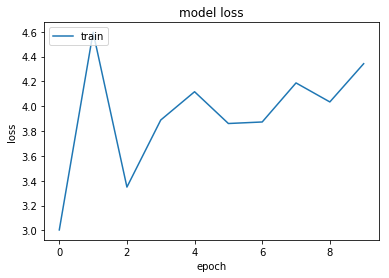

dict_keys(['loss', 'val_loss'])


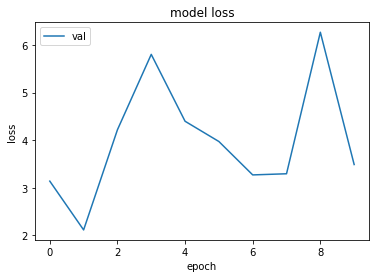

In [116]:
baseline_model, baseline_histroy = run_baseline_model(X_train, y_train, epochs=10)

Train on 12857 samples, validate on 3215 samples
Epoch 1/10
480s - loss: 0.0294 - val_loss: 0.0161
Epoch 2/10
488s - loss: 0.0141 - val_loss: 0.0152
Epoch 3/10
488s - loss: 0.0128 - val_loss: 0.0151
Epoch 4/10
481s - loss: 0.0122 - val_loss: 0.0153
Epoch 5/10
532s - loss: 0.0119 - val_loss: 0.0142
Epoch 6/10
573s - loss: 0.0117 - val_loss: 0.0138
Epoch 7/10
550s - loss: 0.0113 - val_loss: 0.0147
Epoch 8/10
486s - loss: 0.0112 - val_loss: 0.0136
Epoch 9/10
502s - loss: 0.0111 - val_loss: 0.0127
Epoch 10/10
504s - loss: 0.0110 - val_loss: 0.0133
Plotting the model architecture:
saving the model file:lenet_model.model
dict_keys(['loss', 'val_loss'])


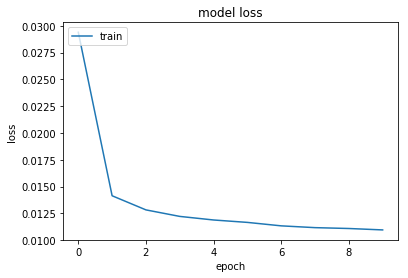

dict_keys(['loss', 'val_loss'])


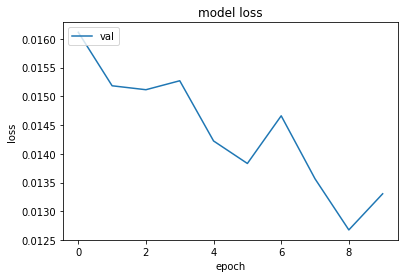

In [60]:
lenet_model, lenet_history = run_lenet_model(X_train, y_train, epochs=10)

Train on 25715 samples, validate on 6429 samples
Epoch 1/10
25715/25715 [==============================] - 922s - loss: 0.0408 - val_loss: 0.0282

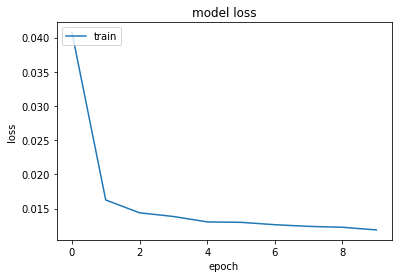

dict_keys(['loss', 'val_loss'])


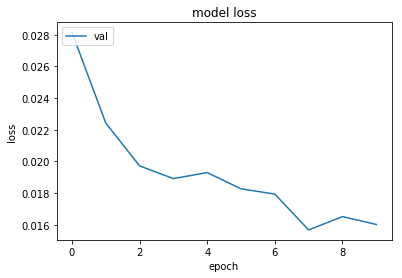

Train on 25715 samples, validate on 6429 samples
Epoch 1/5
25715/25715 [==============================] - 925s - loss: 0.0749 - val_loss: 0.0282

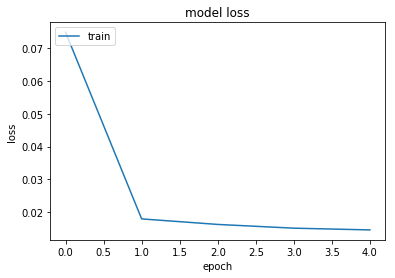

dict_keys(['loss', 'val_loss'])


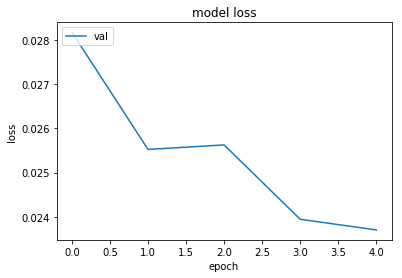

In [121]:
lenet_model_epoch10, lenet_history = run_lenet_model(X_train, y_train, epochs=10)
lenet_model_epoch5, lenet_history = run_lenet_model(X_train, y_train, epochs=5)


Train on 25715 samples, validate on 6429 samples
Epoch 1/10
25715/25715 [==============================] - 676s - loss: 0.1153 - val_loss: 0.0325

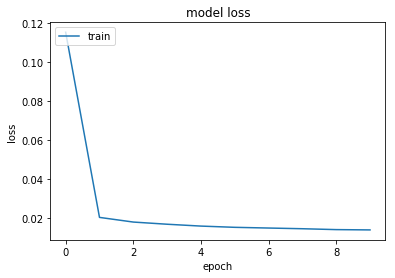

dict_keys(['loss', 'val_loss'])


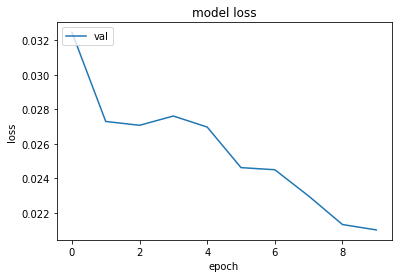

Train on 25715 samples, validate on 6429 samples
Epoch 1/5
25715/25715 [==============================] - 685s - loss: 0.0954 - val_loss: 0.0347

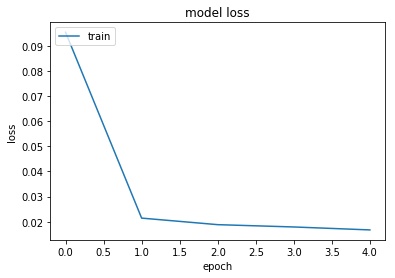

dict_keys(['loss', 'val_loss'])


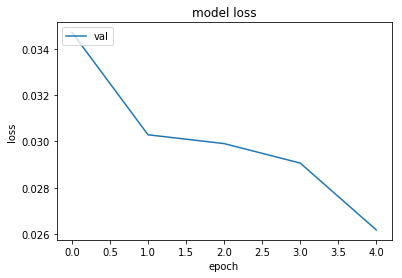

In [162]:
## Lenet With Cropping
lenet_model_epoch10, lenet_history = run_lenet_model(X_train, y_train, epochs=10, model_prefix="_crop_")
lenet_model_epoch5, lenet_history = run_lenet_model(X_train, y_train, epochs=5,   model_prefix="_crop_")


### Nvida architecture run

In [ ]:
# nvida_mode_10, _ = train_run_nvida_model(X_train, y_train, epochs=10, model_prefix="_crop_left_right_flip_")
# nvida_mode, _ = train_run_nvida_model(X_train, y_train, epochs=5, model_prefix="_crop_left_right_flip_")


# Nvida with Generators

In [ ]:
train_run_nvida_model_with_gen(train_generator, validation_generator, len_train_samples, len_valid_samples,
                               model_prefix='crop_with_gen', epochs=1)

/Users/kdalwani/anaconda2/envs/carnd3/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=12, validation_data=<generator..., steps_per_epoch=50, epochs=1)`
  '` call to the Keras 2 API: ' + signature)


Epoch 1/1
 3/50 [>.............................] - ETA: 1613s - loss: 0.4502. . . 

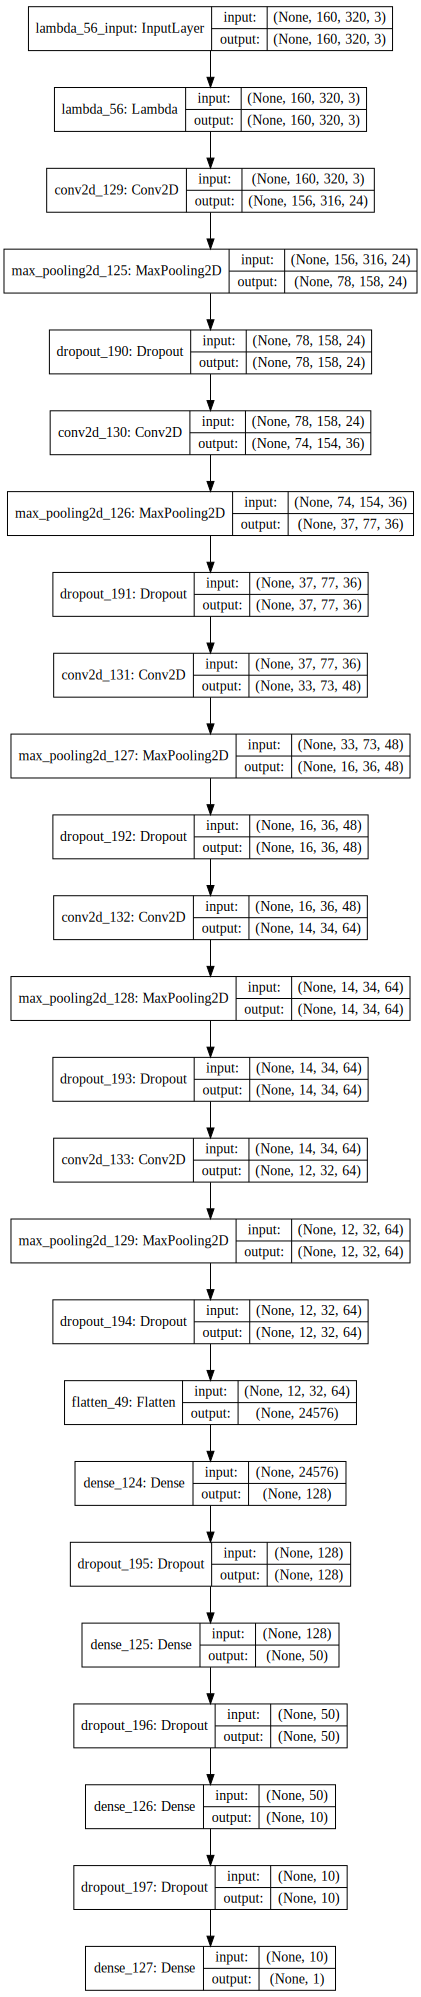

In [179]:
SVG(model_to_dot(create_nvdia_model(dropout=0.5), show_shapes=True).create(prog='dot', format='svg'))
#SVG(model_to_dot(nvida_mode, show_shapes=True).create(prog='dot', format='svg'))



## Baseline model

In [122]:
#SVG(model_to_dot(baseline_model, show_shapes=True).create(prog='dot', format='svg'))

## LeNet model

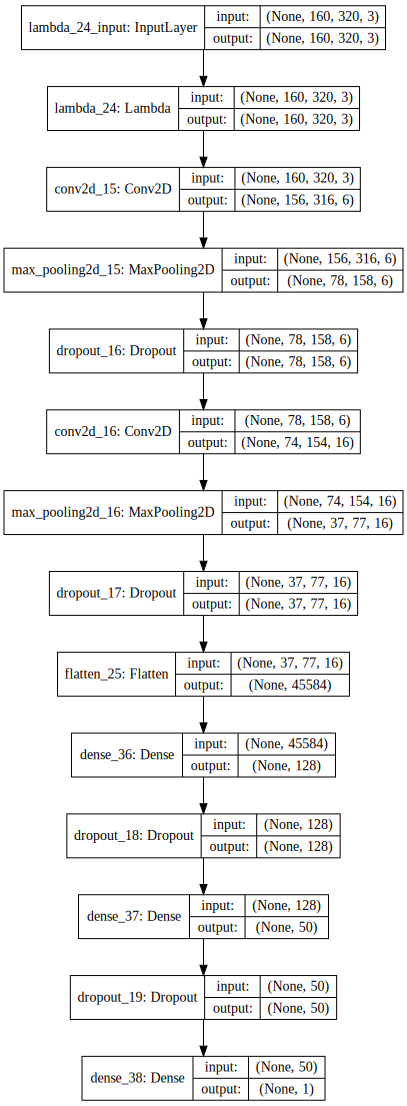

In [145]:
SVG(model_to_dot(lenet_model, show_shapes=True).create(prog='dot', format='svg'))

## Model with Lambda layer

## Log of attemps

- All sample images 
    - Basic architecture of flat + Dense
    - Basic architectire of flat + 100 Dense + Dense
- 2) All sample images + flip images
- (3)=== (2) + lLambda(lambda x: (x/255.0) - 0.5
- Flip images with LeNet
- Multiple Cameras https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/46a70500-493e-4057-a78e-b3075933709d/concepts/2cd424ad-a661-4754-8421-aec8cb018005




### To do next

- Multiple camera CV the correction

- Cropping Image
- NVida architecture
- More data collection